[link dataset](https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k)

# Setup

### command line

In [1]:
!pip install -q split-folders
!pip install -q opendatasets

### import libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2, l1
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib, zipfile, os, splitfolders, datetime
import opendatasets as od

### download dataset

In [3]:
_URL = 'https://www.kaggle.com/datasets/doctrinek/oxford-iiit-cats-extended-10k'
od.download(_URL)

100%|██████████| 993M/993M [00:10<00:00, 99.7MB/s]


### split into train and validation

In [4]:
PATH = '/content/oxford-iiit-cats-extended-10k/CatBreedsRefined-v3'

In [5]:
splitfolders.ratio(PATH, output='/content/project', seed=64, ratio=(0.8, 0.2))
train_dir = '/content/project/train'
validation_dir = '/content/project/val'

Copying files: 10257 files [00:04, 2075.02 files/s]


### define variables

In [6]:
BATCH_SIZE = 32
IMG_SIZE = (224,224)

### create tf.data.Dataset

In [7]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 8202 files belonging to 12 classes.


In [8]:
validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE
)

Found 2055 files belonging to 12 classes.


In [9]:
class_names = train_dataset.class_names
class_indices = {class_name: index for index, class_name in enumerate(class_names)}

print("Class Names:", class_names)
print("Class Indices:", class_indices)

Class Names: ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'Bristish Shorthair', 'Egyptian Mau', 'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']
Class Indices: {'Abyssinian': 0, 'Bengal': 1, 'Birman': 2, 'Bombay': 3, 'Bristish Shorthair': 4, 'Egyptian Mau': 5, 'Maine Coon': 6, 'Persian': 7, 'Ragdoll': 8, 'Russian Blue': 9, 'Siamese': 10, 'Sphynx': 11}


# Data Exploration

### show the first nine images from the training set

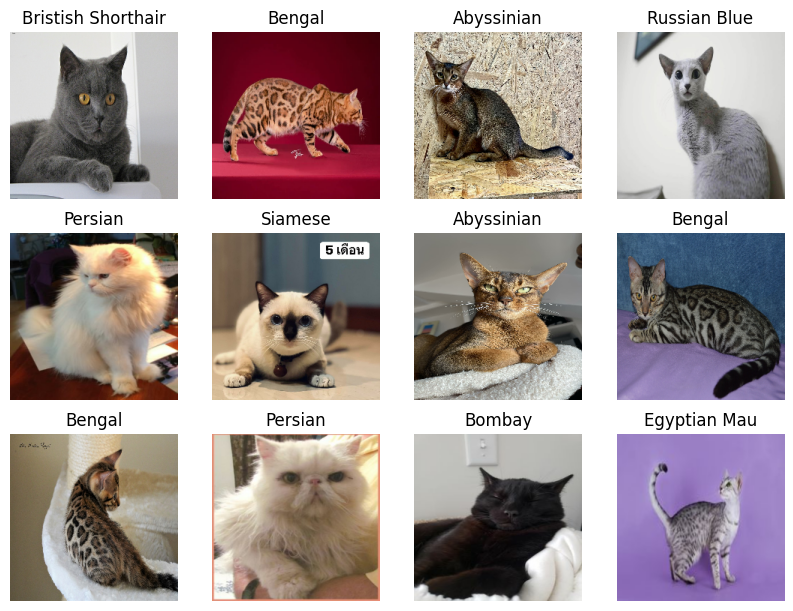

In [10]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for images, labels in train_dataset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### show data samples

In [11]:
def total_sample(directory):
  total = 0
  for folder in os.listdir(directory):
    folder_path = os.path.join(directory, folder)
    total += len(os.listdir(folder_path))

  return total

train_sample_length = total_sample(train_dir)
validation_sample_length = total_sample(validation_dir)
print(f"The train directory has {train_sample_length} samples")
print(f"The validation directory has {validation_sample_length} samples")
print(f"Which in total makes it {train_sample_length + validation_sample_length} samples")

The train directory has 8202 samples
The validation directory has 2055 samples
Which in total makes it 10257 samples


# Preprocessing

### configure dataset performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

### implement data augmentation

In [40]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomZoom(width_factor=0.2, height_factor=0.2),
    tf.keras.layers.RandomWidth(factor=0.1),
    tf.keras.layers.RandomHeight(factor=0.1),
    tf.keras.layers.RandomBrightness(factor=0.15)
])

### visualize data augmentation

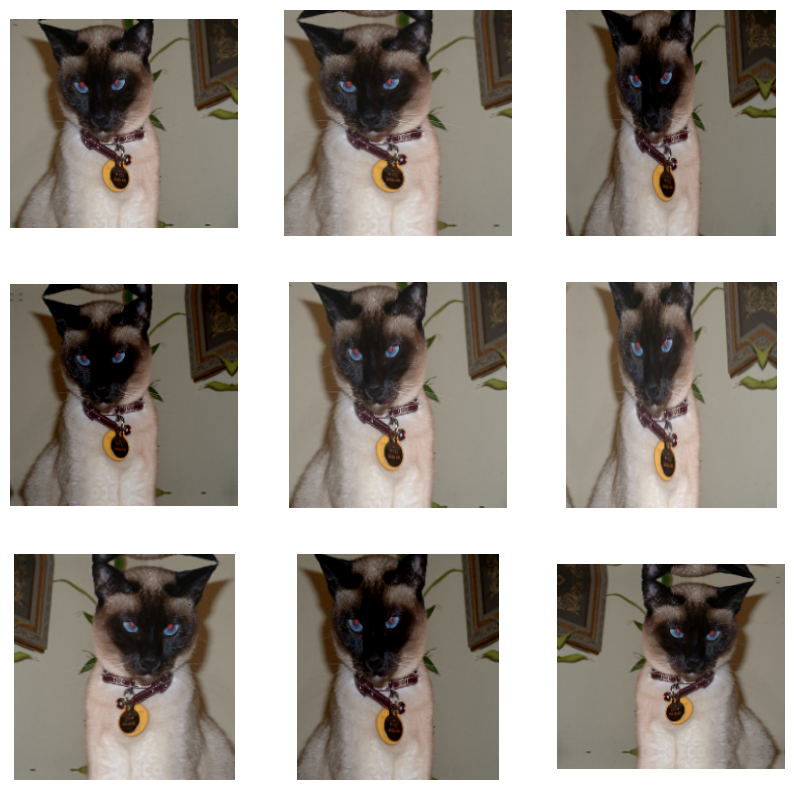

In [41]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10,10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### rescale pixel values

In [42]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

# Model Creation

### callback functions

In [16]:
class SudahWoi(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') >= 0.92 and logs.get('val_accuracy') >= 0.92:
      print(f"The model accuracy has reached 92%, stopping training")
      self.model.stop_training = True

model_complete = SudahWoi()

In [17]:
from tensorflow.keras.callbacks import EarlyStopping
stop_early = EarlyStopping(patience=6, monitor="val_accuracy", restore_best_weights=True, verbose=1)

In [18]:
class learningrateLogger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print(f"Epoch {epoch+1}/{self.params['epochs']}, Learning Rate: {self.model.optimizer.lr.numpy()}")

lr_log = learningrateLogger()

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy",
    factor=0.8,
    patience=3,
    verbose=1,
    mode="max",
    min_lr=0.00001
)

### create base model

In [66]:
IMG_SHAPE = IMG_SIZE + (3,)

base_model = MobileNetV2(
    weights="imagenet",
    input_tensor=Input(shape=IMG_SHAPE),
    include_top=False
)

base_model.trainable = False

In [67]:
model = tf.keras.Sequential()
model.add(Input(shape=(IMG_SHAPE)))
model.add(data_augmentation)
model.add(rescale)
model.add(base_model)
model.add(BatchNormalization())
model.add(Conv2D(96, (3,3), activation=tf.nn.relu))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation=tf.nn.relu))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(128, activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(Dense(12, activation=tf.nn.softmax))

In [68]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_12 (Ba  (None, None, None, 1280   5120      
 tchNormalization)           )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 96)    1106016   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, None, None, 96)   

In [70]:
int_lr = 1e-3
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=int_lr),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [71]:
initial_epochs = 20

loss0, acc0 = model.evaluate(validation_dataset)

65/65 [==============================] - 15s 154ms/step - loss: 2.8238 - accuracy: 0.0783


In [72]:
modelku = model.fit(
    train_dataset,
    epochs=initial_epochs,
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[model_complete]
)

Epoch 1/20
257/257 - 66s - loss: 0.7934 - accuracy: 0.7330 - val_loss: 0.5292 - val_accuracy: 0.8151 - 66s/epoch - 255ms/step
Epoch 2/20
257/257 - 60s - loss: 0.5512 - accuracy: 0.8109 - val_loss: 0.4705 - val_accuracy: 0.8472 - 60s/epoch - 234ms/step
Epoch 3/20
257/257 - 59s - loss: 0.4838 - accuracy: 0.8346 - val_loss: 0.4382 - val_accuracy: 0.8482 - 59s/epoch - 229ms/step
Epoch 4/20
257/257 - 60s - loss: 0.4288 - accuracy: 0.8544 - val_loss: 0.4600 - val_accuracy: 0.8482 - 60s/epoch - 234ms/step
Epoch 5/20
257/257 - 60s - loss: 0.3900 - accuracy: 0.8627 - val_loss: 0.4665 - val_accuracy: 0.8443 - 60s/epoch - 232ms/step
Epoch 6/20
257/257 - 61s - loss: 0.3642 - accuracy: 0.8772 - val_loss: 0.4662 - val_accuracy: 0.8482 - 61s/epoch - 236ms/step
Epoch 7/20
257/257 - 59s - loss: 0.3376 - accuracy: 0.8820 - val_loss: 0.4606 - val_accuracy: 0.8501 - 59s/epoch - 228ms/step
Epoch 8/20
257/257 - 68s - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.4499 - val_accuracy: 0.8564 - 68s/epoch - 264

### plot transfer learning

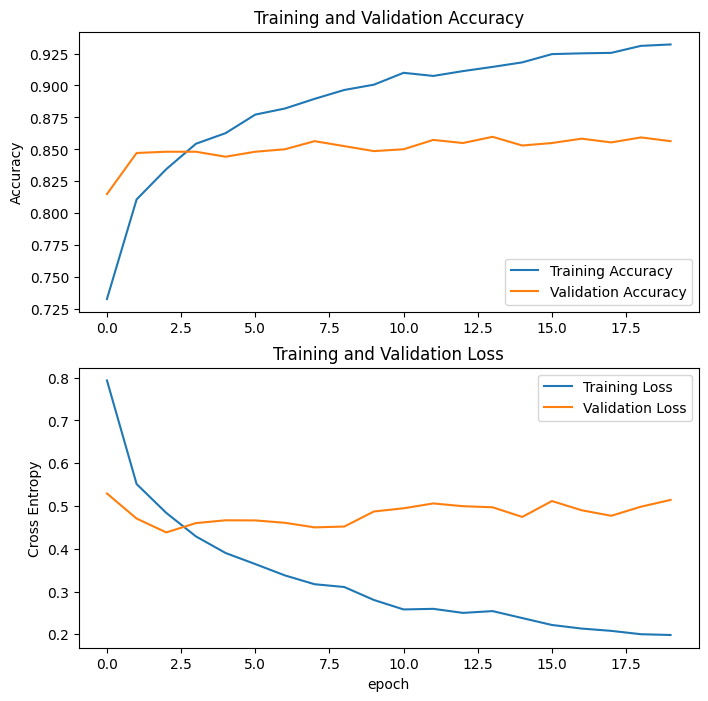

In [73]:
acc = modelku.history['accuracy']
val_acc = modelku.history['val_accuracy']

loss = modelku.history['loss']
val_loss = modelku.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine Tuning

In [74]:
base_model.trainable = True

In [75]:
print("Jumlah layer di base_model: ", len(base_model.layers))

fine_tune_di = 100

for layer in base_model.layers[:fine_tune_di]:
  layer.trainable = False

Jumlah layer di base_model:  154


In [76]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=int_lr/10),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, None, None, 3)     0         
                                                                 
 rescaling_1 (Rescaling)     (None, None, None, 3)     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 batch_normalization_12 (Ba  (None, None, None, 1280   5120      
 tchNormalization)           )                                   
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 96)    1106016   
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, None, None, 96)   

In [78]:
fine_tune_epochs = 20
total_epochs = initial_epochs + fine_tune_epochs

modelku_fine = model.fit(
    train_dataset,
    epochs=total_epochs,
    initial_epoch=modelku.epoch[-1],
    validation_data=validation_dataset,
    verbose=2,
    callbacks=[stop_early, reduce_lr, lr_log, model_complete]
)

Epoch 20/40
Epoch 20/40, Learning Rate: 9.999999747378752e-05
257/257 - 74s - loss: 0.5095 - accuracy: 0.8424 - val_loss: 0.5454 - val_accuracy: 0.8321 - lr: 1.0000e-04 - 74s/epoch - 286ms/step
Epoch 21/40
Epoch 21/40, Learning Rate: 9.999999747378752e-05
257/257 - 61s - loss: 0.3177 - accuracy: 0.8936 - val_loss: 0.5157 - val_accuracy: 0.8418 - lr: 1.0000e-04 - 61s/epoch - 238ms/step
Epoch 22/40
Epoch 22/40, Learning Rate: 9.999999747378752e-05
257/257 - 59s - loss: 0.2429 - accuracy: 0.9147 - val_loss: 0.4399 - val_accuracy: 0.8647 - lr: 1.0000e-04 - 59s/epoch - 231ms/step
Epoch 23/40
Epoch 23/40, Learning Rate: 9.999999747378752e-05
257/257 - 61s - loss: 0.1970 - accuracy: 0.9328 - val_loss: 0.4323 - val_accuracy: 0.8710 - lr: 1.0000e-04 - 61s/epoch - 239ms/step
Epoch 24/40
Epoch 24/40, Learning Rate: 9.999999747378752e-05
257/257 - 60s - loss: 0.1730 - accuracy: 0.9396 - val_loss: 0.4686 - val_accuracy: 0.8564 - lr: 1.0000e-04 - 60s/epoch - 232ms/step
Epoch 25/40
Epoch 25/40, Learn

### plot fine tuning

In [79]:
acc += modelku_fine.history['accuracy']
val_acc += modelku_fine.history['val_accuracy']

loss += modelku_fine.history['loss']
val_loss += modelku_fine.history['val_loss']

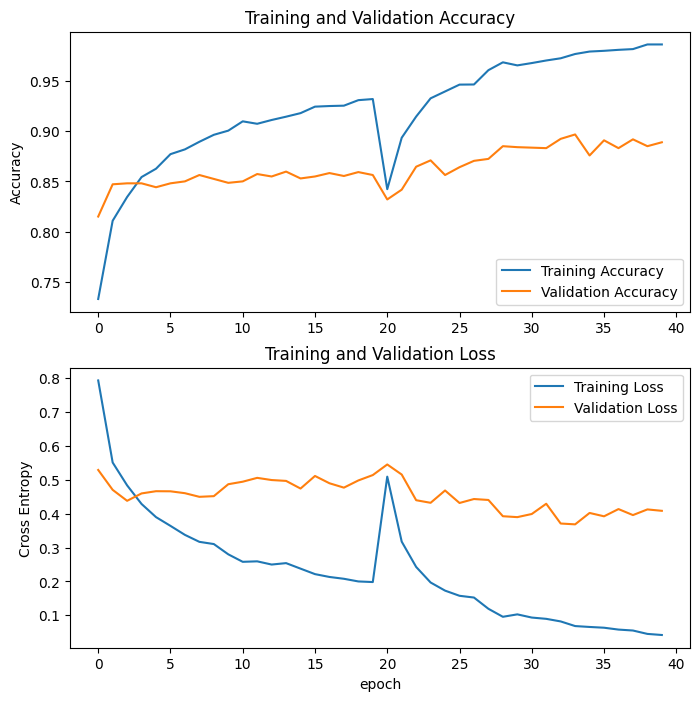

In [80]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# model evaluation

In [81]:
loss, accuracy = model.evaluate(validation_dataset)
print('Validation accuracy :', accuracy)

65/65 [==============================] - 13s 162ms/step - loss: 0.3687 - accuracy: 0.8968
Validation accuracy : 0.8968369960784912


### predict image

In [82]:
from google.colab import files
uploaded = files.upload()

Saving Abyssinian_10.jpg to Abyssinian_10.jpg
Saving bengal_1.jpg to bengal_1.jpg
Saving Bristish Shorthair_1.jpg to Bristish Shorthair_1.jpg
Saving Ragdoll_1.jpg to Ragdoll_1.jpg
Saving Russian Blue_10.jpg to Russian Blue_10.jpg


1/1 [==============================] - 0s 35ms/step


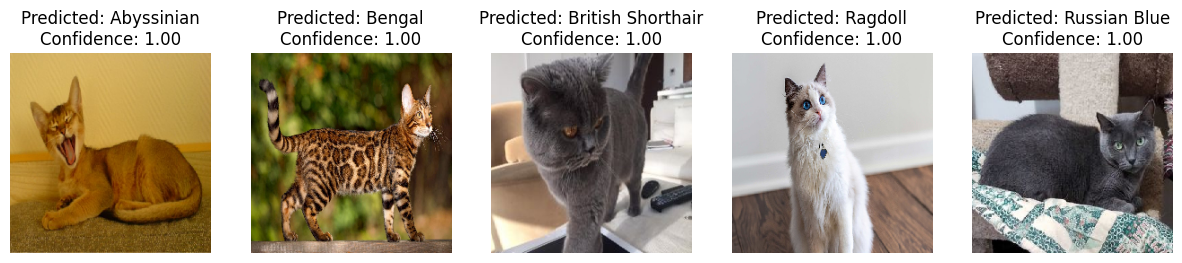

In [83]:
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg
%matplotlib inline

class_labels = ['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British Shorthair', 'Egyptian Mau',
                'Maine Coon', 'Persian', 'Ragdoll', 'Russian Blue', 'Siamese', 'Sphynx']

fig , axs = plt.subplots(1, len(uploaded), figsize=(15,5))

for i, fn in enumerate(uploaded.keys()):

  #predict gambar
  path = fn
  img = image.load_img(path, target_size=IMG_SIZE)

  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images, batch_size=10)
  predicted_index = np.argmax(classes)
  confidence_score = classes[0][predicted_index]

  predicted_label = class_labels[predicted_index]

  axs[i].imshow(img)
  axs[i].set_title(f"Predicted: {predicted_label}\nConfidence: {confidence_score:.2f}")
  axs[i].axis('off')

plt.show()

# Save Model

In [84]:
# menyimpan model dalam format saved model
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

# convert SavedModel menjadi vegs.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('vegs.tflite')
tflite_model_file.write_bytes(tflite_model)

13773432